<center>
<img src="../../img/ods_stickers.jpg" />
    
## Author's identification
Authors: [Sergey Ustyantsev]() (@schokoro).

This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

### Problem description

In literature and history, there is often a question about the recognition of literary works and the recognition of the authorship of one or another author. Did one person write Plato's dialogues? Did the same genius write all Shakespeare's plays? Alternatively, did different people create all those works? For a long time, there was a discussion about the identity of the author of the novel "And Quiet Flows the Don", and whether Mikhail Sholokhov did write it. Finally, the linguistic examinations made in 1984, 1999 and 2007 proved Sholokhov's authorship.
Now, there is a similar situation concerning the novels "The Twelve Chairs" and "The Golden Calf". Officially, the authors of the novels are Illya Ilf and Yevgeny Petrov. However, there is an alternative hypothesis that the real author of those novels was Mikhail Bulgakov. The version was studied from a literary and historical point of view \[1\], \[2\], but so far, I have not met linguistic studies on this subject. In this project, I will try to fill the gap and,   let's say, check the harmony with the help of algebra.
Currently, there are many ways to determine the numerical characteristics of texts based on the style of the author of the text. Such characteristics allow us to recognise the author and are called the author's invariant. One of these methods is the object of research in this project.
### Problem definition 
In this project, we will
* Investigate the method of recognising authorship based on calculating the trigrams.
* Determine the optimal parameters of the method for solving the problem defined.
* Confirm or disprove the hypothesis that the author of the novels "12 chairs" and "The Golden Calf" was Mikhail Bulgakov.

### Problem formalisation. Solution methods.
We will formulate the problem of recognising the author of a text with a limited set of alternatives as follows.
There are a set of texts $T = \{ t_{1},..., t_{k} \}$ and a set of authors $A = \{ a_{1},..., a_{n}\}$. For some subset of the texts $T^{'} \subseteq T$, the authors are known $D = \{(t_{i},\ a_{i})\}^{l}_{i=1}$. It is necessary to find the real author $A$ of the texts (whether they are anonymous or controversial) $T^{''}=\{t_{|T|+1},...,\ t_{k}\} \subseteq T$.<br>
The main methods used in this project are discribed in the works \[3\], \[4\]. The parameters of the models found in these works differ somewhat but do not contradict each other. The essence of the method is as follows.
The text can be viewed as a hierarchical structure and analysed at any level as a sequence of individual constituent elements (characters, word forms, grammar classes, etc.) or groups of elements of length N, called N-grams. Text analysis looks more complicated when using features of higher levels of the hierarchy. So, in the process of morphological analysis, information obtained at the stage of lexical analysis is used, and at the stage of syntactic analysis, information obtained at the stage of morphological analysis etc. is used. In this study, we confine ourselves to character level characteristics; namely, we will use character trigram calculations as a tool.

In the works mentioned above, they used Support Vector Machine with a linear kernel, in one case, and a radial basis function kernel, in another case as the machine learning algorithms. The common disadvantage of those works was the lack of adjustment of the hyper-parameters of the models. Primarily, it concerns the learning rate with the assumed value of $C = 1$, by default. When performing modelling, in this project, it was found that the optimal values of $С$ lie in the range of $10^{-9} ... 10^{-1}$ and depend on the model and the specific dataset.

We will calculate the frequencies of appearing the trigrams in substrings of length from 1000 to 25000 symbols, mentioning that the size of the corpus is limited. In each substring, we will calculate the frequencies for the most frequently encountered $N$  trigrams with $N \in \{100 ... 2000\}$. Besides, to estimate the probabilities of appearing the trigrams, we will apply the method of the Laplacian smoothing, and check whether it affects the model's work.

### The method reasoning and the preparation of the corpus of text data

The primary requirements for the corpus of text data prepared for conducting linguistic studies are representativeness and balance \[5\]. The first requirement means that the language model presented in the corpus is statistically significant. The second requirement means that the texts gathered in the corpus represent the data evenly.<br>
To recognise the authors, we prepared the corpus consisting of literary works written in the 1920s and 1930s. The choice was due to the following circumstances. In the 1920s, on the territories where the Russian-speaking people lived (first of all, on the territory of the Soviet Union), significant social changes took place, and the general way of life changed.<br>
Equally, the Russian language reflected the changes in the forms of Newspeak and other changes. All that also affected the language model, made it different as to the model established later in the middle of the 20th century, so to the language people used to speak before the revolutionary events of 1917.
As we mentioned above, the corpus fo texts included works written in the second half of the 1920s and the first half of the 1930s. Perhaps these restrictions are redundant, but they allow getting a language samples for a certain period.<br>
To train the models we will use the "train" corpus which is, in turn, the subset of the "big" corpus. It includes works by Mikhail Bulgakov, Arkady Gaidar, Maxim Gorky, Alexander Grin, Ilya Ilf and Evgeny Petrov (in collaboration), Valentin Kataev, Yuri Olesha, Andrei Platonov. We used the "big" corpus to build a language model, that is, to calculate the frequencies of appearing the trigrams of characters. Besides the authors presented in the "big" corpus, we added a set of authors from the same period to the model.<br>
All texts presented are in lowercase. We removed the punctuation marks,   numbers and spaces that allowed us taking the bigrams on the boundary of two words into account when analysing. Thus, each work was a solid line consisting of alphabetic characters only.<br>
We prepared the "test" corpus by the same principle. We used the "test" corpus not to calculate trigram frequencies or model training, but only for model testing purposes. The "test" corpus included the works of the same authors presented in the "train" corpus. Controversial works of Ilf and Petrov has been placed in a separate directory. <br>
All prepared data [you can download here](https://drive.google.com/open?id=1fBhxBPXocqlkojMCBGvRnPkYiCH-JMV3)



###  Trigrams estimating, comparison  authors by trigram frequencies


Let's estimate the number of trigrams found for the authors included in the "big" corpus and the "training" corpus.

In [1]:
import re
from tqdm import tqdm_notebook
import pandas as pd
from matplotlib import pyplot as plt
from os import path, listdir
import seaborn as sns
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pdb
import warnings
from pylab import rcParams
import random
from collections import defaultdict
from gc import collect
rcParams['figure.figsize'] = 12, 6
warnings.simplefilter('ignore')
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'


In [2]:
def make_freq_dict(file, f_dict, verbose=False):
    with open(file, 'r') as file_obj:
        string = file_obj.read()
    length = len(string)
    if verbose:
        print(f'{path.split(file)[1]} - {length} symbols')
    for i in range(length-2):
        ngram = string[i:i + 3]
        f_dict[ngram] = f_dict.get(ngram, 0) + 1
    if verbose:        
        print(f'В словаре {len(f_dict)} триграмм')
    return f_dict

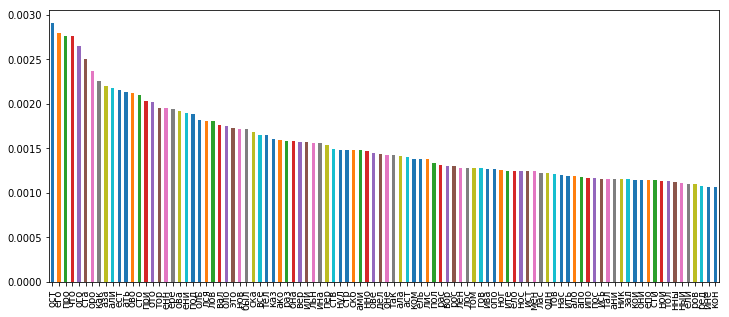

In [3]:
f_dict = {}
full_corps = ''
PATH = '../corpus/'
files = listdir(PATH)
for file in files:
    f_dict = make_freq_dict(path.join(PATH, file), f_dict)
df = pd.Series(f_dict) 
df /= df.sum()
df.sort_values(ascending=False, inplace=True)
rcParams['figure.figsize'] = 12, 5
df.head(100).plot(kind='bar');

The graph shows that seven of the trigrams are significantly higher than the others. Perhaps we must consider them as “garbage” due to their relative frequency and discard, but on the other hand, they may serve as clear signs. We will verify them during further experiments, as well.
Let's compile individual vocabularies of frequencies for the following authors: Bulgakov, Ilf & Petrov, Olesha, Platonov and display 25 of the most frequently used trigrams in joint, and 25 of the most frequently used trigrams for each author individually.


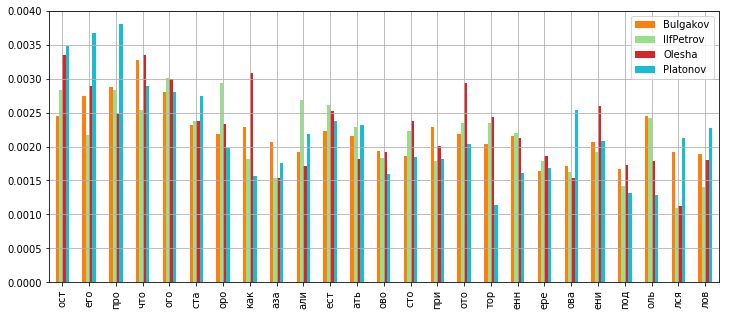

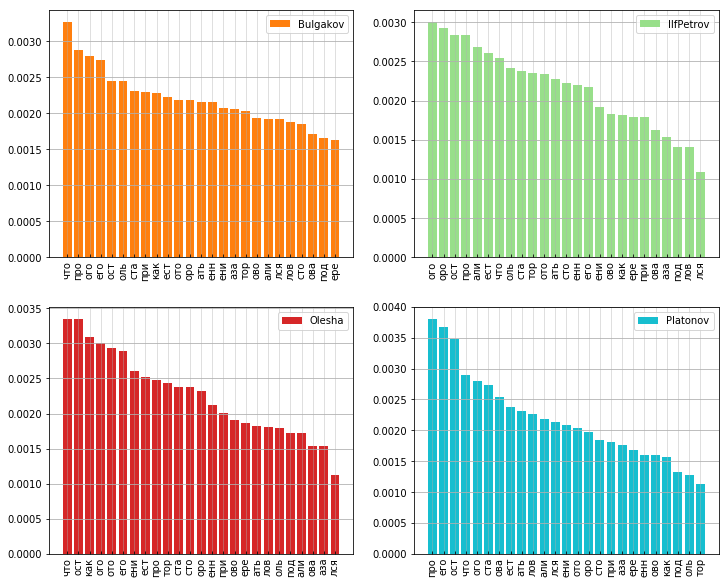

In [4]:
authors = ['Bulgakov', 'IlfPetrov', 'Olesha', 'Platonov']
colors = ['#ff7f0e','#98df8a', '#d62728', '#17becf']
#mp_colors = cm.set_array(np.array(colors))
all_dict = {}
for author in authors:
    f_dict = {}
    full_corps = ''
    PATH = '../corpus/'
    files = listdir(PATH)
    for file in files:
        if file.split('_')[0] == author:
            f_dict = make_freq_dict(path.join(PATH, file), f_dict)
    series_dict = pd.Series(f_dict)
    series_dict /= series_dict.sum()
    all_dict[author] = series_dict
    
particular_fdict = pd.DataFrame(all_dict)
particular_fdict = particular_fdict.loc[df.head(25).index]
particular_fdict.plot(kind='bar', grid=True, colors=colors);

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10));

axes = axes.flatten()
for i, author in enumerate(authors):
    df = particular_fdict[author].sort_values(ascending=False)
    axes[i].bar(df.index, df.values, color=colors[i]);
    axes[i].tick_params(axis='x', direction='in',labelrotation=90, grid_alpha=0.5);
    axes[i].legend([author]);
    axes[i].grid();

The graphs show that different frequencies of different trigrams correspond to different authors, and each author has his own "top-25", which means that these frequencies can be used as *features* for recognition.<br>
I composed the `Recognizer` class to work with the corpus. The descriptions of the main class methods are below.

In [5]:
class Recognizer:
    def __init__(self, corpus_path):
        """
        :param corpus_path: path to corpus directory with string-books
        """
        self.path = corpus_path
        self.authors = ['Bulgakov', 'Gaidar', 'Gorky', 'Grin', 'IlfPetrov',
                        'Kataev', 'Olesha', 'Platonov']
        self.f_dict = defaultdict(int)
        self.string_corps = {writer: '' for writer in self.authors}
        self.make_dict_and_corps()
        self.trigrams = []
        self.estimators = {}

    def set_lang_model(self, string_size=5000, lang_model_size=100, skip=0, smoothing=False):
        """
        Sets parameters of language model
        :param string_size: length of substring
        :param lang_model_size: nums of the most frequently used trigrams for analys
        :param skip: num of skipped trigramms
        :param smoothing: on/off Laplacian smoothing
        """
        self.estimators = {}
        self.string_size=string_size
        self.trigrams = list(self.all_trigrams[skip: lang_model_size + skip].index)
        self.smoothing = smoothing

    def make_dict_and_corps(self):
        """
        Make dictionary and corpus for all authors in self.authors
        """
        books = listdir(self.path)
        for book in books:
            author = book.split('_')[0]
            with open(path.join(self.path, book)) as book_obj:
                string = book_obj.read()
                length = len(string)
                for i in range(length - 2):  # make a trigrams from string
                    ngram = string[i:i + 3]
                    self.f_dict[ngram] += 1
                if author in self.authors:
                    self.string_corps[author] += string
        self.all_trigrams = pd.Series(self.f_dict)
        self.all_trigrams.sort_values(ascending=False, inplace=True)

    def makesample(self, author, count=0, reverse=False, random_state=None):
        """
        :param author:
        :param count:0
        :param reverse: if True, method returns subsamples for all authors accept *author*
        :return: returns dataframe with trigrams frequencies
        """
        df_list = []
        if reverse:

            count *= len(self.authors) - 1
            string = ''
            for person in self.string_corps:
                if person is not author:
                    string += self.string_corps[person]
        else:
            string = self.string_corps[author]
        len_ = len(string)
        if count * self.string_size > len_:
            raise ValueError(f"{author} hasn't got a required text size ({count * self.string_size}) symbols.")
        if count == 0:
            count = len_ // self.string_size
        string_list = [string[i * self.string_size: ((i + 1) * self.string_size)] for i in range(len_ // self.string_size)]  # make a substrings
        random.seed(random_state)
        string_list = random.sample(string_list, count)
        for string in string_list:
            df_list.append(self.evaluate_trigrams(string))

        return pd.DataFrame(df_list)

    def evaluate_trigrams(self, substring):
        """
        Calculates frequencies of top-trigrams in string
        :param substring: input string (str)
        :return: dictionary, where keys are trigrams and values are trigrams frequencies
        """
        dyct = {key: 0 for key in self.trigrams}
        len_ = len(substring)
        count = 0
        for i in range(len_ - 2):
            ngram = substring[i:i + 3]
            if ngram in dyct:
                dyct[ngram] += 1
                count += 1
        if self.smoothing:
            return {key: (dyct[key] + 1)/(count + len(self.trigrams)) for key in dyct}
        else:
            return {key: dyct[key]/count for key in dyct}

    def one_against_one(self, model, params, author_1, author_2, scoring,
                        count=25, verbose=False, random_state=None):
        """
        Selects the optimal learning rate for the ML-model, 
        performs cross-validation of the model with the given parameters and authors.
        :param model: ML-model (sklearn model object)
        :param params: parameters of ML-model (dict)
        :param author_1: author_1 (str)
        :param author_2: author_2 (str)
        :param scoring: scoring
        :param count: number of substrings in sample
        :param verbose: 
        :return: mean value and standard deviation for cross_validation

        """
        if random_state:
            random_state1 = (hash(author_1) * random_state) % hash(author_2)
            random_state2 = (hash(author_2) * random_state) % hash(author_1)
        else:
            random_state1 = random_state2 = None
        model_name = re.findall(r'\w+', str(model).lower())[-1]  # it's a kind of magic
        cv = 5 if count > 5 else count
        df1 = self.makesample(author=author_1, count=count, random_state=random_state1)
        df2 = self.makesample(author=author_2, count=count, random_state=random_state2)
        y = np.hstack((np.ones(df1.shape[0]).astype(np.int), np.zeros(df1.shape[0]).astype(np.int)))
        pipe = make_pipeline(StandardScaler(), model(**params))
        X = pd.concat([df1, df2], axis=0)
        grid_params = {model_name + '__C': np.logspace(-8, 1, 10)}
        grid = GridSearchCV(pipe, param_grid=grid_params, scoring=scoring, n_jobs=-1, cv=cv, verbose=False).fit(X, y)
        cross_val = cross_val_score(grid.best_estimator_, X, y, cv=count, n_jobs=-1, scoring=scoring)
        mean_ = cross_val.mean()
        std_ = cross_val.std()
        if verbose:
            print(f'| mean = {cross_val.mean():.2f}, std = {cross_val.std():.2f} |')
        return np.array([mean_, std_])

    def make_df(self, text_path):
        """
        It gets a path to text-file, cuts the file into substrings of 'self.string_size' characters and calculates trigrams
         frequencies. Returns dataframe with trigrams frequencies.
        :param text_path: path to text file
        :return: pd.DataFrame
        """
        with open(text_path, 'r') as text_obj:
            string = text_obj.read()
        df_list = []
        len_ = len(string)
        string_list = [string[i * self.string_size: ((i + 1) * self.string_size)] \
                       for i in range(len_ // self.string_size)]
        for string in string_list:
            df_list.append(self.evaluate_trigrams(string))
        return pd.DataFrame(df_list)

    @staticmethod
    def softmax(X):
        """
        My own softmax with numpy and vecotorizing :7
        """
        y = np.atleast_2d(X)
        y = y - np.expand_dims(np.max(y, axis=1), 1)
        y = np.exp(y)
        ax_sum = np.expand_dims(np.sum(y, axis=1), 1)
        p = y / ax_sum
        if len(X.shape) == 1:
            p = p.flatten()
        return p

    def fit(self, model, params, mode, train_size=25, random_state=None):
        """
        Fit the ML-models according to the given training data.
        :param model: ML-model (sklearn model object)
        :param params: parameters of ML-model
        :param mode: 'oao' - one-against-one or 'oaa' - one-against-all
        :param train_size: length of string for evaluate trigrams
        :return: None
        """
        self.mode = mode
        self.random_state = random_state
        self.train_size = train_size
        self.model = model
        self.params = params
        model_name = re.findall(r'\w+', str(model).lower())[-1]
        cv = 5 if train_size > 5 else train_size
        if not self.trigrams:
            raise RuntimeWarning(' Set a language model first!')
        n_authors = len(self.authors)
        self.estimators = {}
        for i in range(n_authors):
            df1 = self.makesample(author=self.authors[i], count=train_size, random_state=random_state + i)
            if mode == 'oao': # one against one
                for j in range(i):
                    df0 = self.makesample(author=self.authors[j], count=train_size, random_state=random_state + 3*i + 5*j)
                    X = pd.concat([df1, df0], axis=0)
                    y = np.hstack((np.ones(df1.shape[0]).astype(np.int),
                                   np.zeros(df0.shape[0]).astype(np.int)))
                    pipe = make_pipeline(StandardScaler(), model(**params))
                    grid_params = {model_name + '__C': np.logspace(-9, 1, 21)}
                    grid = GridSearchCV(pipe, param_grid=grid_params,
                                        scoring='accuracy',
                                        n_jobs=-1,
                                        cv=cv).fit(X, y)
                    self.estimators[frozenset([self.authors[i], self.authors[j]])] = {
                        'estimator': grid.best_estimator_,
                        'target': [self.authors[j], self.authors[i]]
                    }
            elif mode == 'oaa': # one against all
                df0 = self.makesample(author=self.authors[i], count=train_size, reverse=True)
                X = pd.concat([df1, df0], axis=0)
                y = np.hstack((np.ones(df1.shape[0]).astype(np.int),
                               np.zeros(df0.shape[0]).astype(np.int)))
                pipe = make_pipeline(StandardScaler(), model(**params))
                grid_params = {model_name + '__C': np.logspace(-9, 1, 21)}
                grid = GridSearchCV(pipe, param_grid=grid_params, scoring='roc_auc', n_jobs=-1).fit(X, y)
                self.estimators[self.authors[i]] = grid
        return

    def predict(self, text_path):
        """
        Возвращает автора из корпуса, максимально соответствующего тексту. Выбор осуществляется мажоритарным
        голосованием по accuracy.
        :param text_path:
        :return: string: author of input text (tuple of strings)
        """
        if not self.estimators:
            raise RuntimeWarning("Run 'fit'-method first")
        test_df = self.make_df(text_path)
        result = defaultdict(int)
        df_result = pd.DataFrame(index=test_df.index, columns=self.authors).fillna(0)
        for key in self.estimators:
            if self.mode == 'oaa':  # one against all
                pred = self.estimators[key].predict(test_df).sum()
                result[key] += pred
                df_result[key] = self.estimators[key].predict(test_df)
            elif self.mode == 'oao': # one against one
                estimator = self.estimators[key]['estimator']
                target = self.estimators[key]['target']
                df_result[target[1]] += estimator.predict(test_df)
                df_result[target[0]] += -1 * (estimator.predict(test_df) -1)
            else:
                raise ValueError("incorrect parameter value")
        author_sum = df_result.sum()
        return author_sum[author_sum == author_sum.max()].index[0]

    def hypothesis_test(self, text_path, author_1, author_2, softmax=False):
        """
        Returns the probabilities of a work accessory for two  authors.
        :param text_path: path to text file
        :param author_1: first author
        :param author_2: second author
        :return: pd.Series of probabilities
        """
        if not self.estimators:
            raise RuntimeWarning("Run 'fit'-method first")
        if self.random_state:
            random_state1 = (hash(author_1) * self.random_state) % hash(author_2)
            random_state2 = (hash(author_2) * self.random_state) % hash(author_1)
        else:
            random_state1 = random_state2 = None

        keys = list(self.estimators.keys())
        test_df = self.make_df(text_path)

        if self.mode == 'oao':
            dict_estimator = self.estimators[frozenset([author_1, author_2])]
            target = dict_estimator['target']
            pred = dict_estimator['estimator'].predict(test_df)
            pred = pred.sum()/test_df.shape[0]
            return pd.Series({target[1]: pred, target[0]: 1 - pred})

        elif self.mode == 'oaa':
            if softmax:
                pred1 = self.estimators[author_1].predict_proba(test_df)
                pred2 = self.estimators[author_2].predict_proba(test_df)
                pred = self.softmax(np.vstack((pred1[: ,1], pred2[: ,1].T)).T)
                #print(pred)
                #pdb.set_trace()
                return pd.Series(pred.mean(axis=0), index=[author_1, author_2])
            else:
                model = self.model
                model_name = re.findall(r'\w+', str(model).lower())[-1]
                cv = 5 if self.train_size > 5 else self.train_size
                df1 = self.makesample(author=author_1, count=self.train_size, random_state=random_state1)
                df0 = self.makesample(author=author_2, count=self.train_size, random_state=random_state2)

                X = pd.concat([df1, df0], axis=0)
                y = np.hstack((np.zeros(df1.shape[0]).astype(np.int), np.ones(df0.shape[0]).astype(np.int)))
                pipe = make_pipeline(StandardScaler(), model(**self.params))
                grid_params = {model_name + '__C': np.logspace(-9, 1, 21)}
                grid = GridSearchCV(pipe, param_grid=grid_params, scoring='roc_auc', n_jobs=-1, cv=cv).fit(X, y)
                #pdb.set_trace()
                pred = grid.predict_proba(test_df)
                return pd.Series(pred.mean(axis=0), index=[author_1, author_2])
        else:
            raise KeyError


##### Class Description
The class constructor has one mandatory parameter, that is the path to the corpus of the texts used to train the model.<br>
* The ***set_lang_model*** method adjusts the parameters of the language model, that is, the number of trigrams used, the length of the substring to calculate the number of trigrams, the number of skipped initial trigram and switching on or switching off the smoothing.
* The ***one_against_one*** method get a class of machine learning model at the input, that is, two authors and samples size. Then, the `makesample` method creates samples of the text of a given size for each author. Then, method selects the optimal learning rate for the ML-model, with the help of `GridSearchCV`. Finally, the method calculates the probability of the correct recognition of the author in cross-validation for the best estimator. The number of folds is equal to the number of substrings in samples for each author. Since the sample sizes are relatively small, cross-validation does not take much time.
* The ***fit*** method teaches M classifiers for N authors on subsamples of a given size. For the scheme `one against one` $M = \frac{N(N-1)}{2}$, for the scheme` one against all` $M=N$
* The ***predict*** method receives the path to the text file and returns the author for the text using the trained classifiers.
* The ***hypothesis_test*** method get the path to the text file, two authors and returns the probabilities of belonging the specified texts to the specified authors.

.

In [6]:
recognizer = Recognizer('../corpus/')

We will fix the length of substings equal to 5000 characters and estimate the probability of the correct recognition of the author for different amounts of the most common trigrams in the range of 100 to 3000 and conduct experiments for the `SVM` with the linear and rbf kernel and with the logistic regression. Since the SVM algorithm cannot predict the class probabilities, it only returns the class labels, using `'accuracy'`  as the metrics. For `LogisticRegression`, we will also use metric `'accuracy'`  for correct comparison with SVM.

In [7]:
def calculate_errors(recognizer, model, params, scoring='accuracy', length_string=5000,
                     n_3gramms=300, random_state=None):
    recognizer.set_lang_model(lang_model_size=n_3gramms, skip=0, smoothing=False, string_size=length_string)
    errors = {}
    authors = recognizer.authors
    n_authors = len(authors)
    for i in range(n_authors):
        for j in range(i):
            mean, std = recognizer.one_against_one(model, params, authors[i], authors[j],
                                                   scoring, 20, random_state=random_state)
            errors['_'.join([authors[i], authors[j]])] = (mean)
    return errors

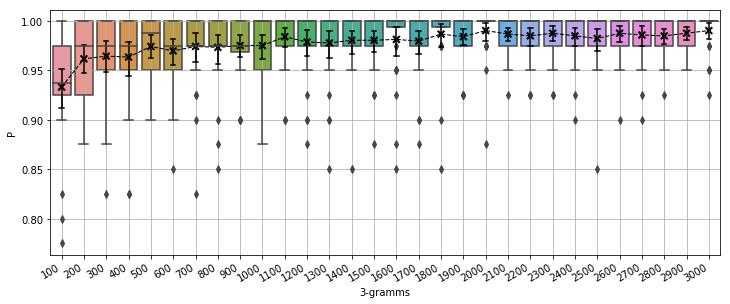

In [8]:
#SVM with linear kernel
params = {'random_state':42, 'kernel': 'linear'} 
df_list = {}
for ngrams in tqdm_notebook(range(100, 3100, 100)):
    df_list[ngrams] = calculate_errors(recognizer, SVC, params, n_3gramms=ngrams, random_state=ngrams)
df_errors_svl = pd.DataFrame(df_list)
f, ax = plt.subplots(1, 1)
sns.boxplot(data=df_errors_svl, ax=ax);
sns.pointplot(data=df_errors_svl.values, linestyles='', scale=1, color='k', errwidth=1.5, capsize=0.2, markers='x')
sns.pointplot(data=df_errors_svl.values, linestyles='--', scale=0.4, color='k', errwidth=0, capsize=0, ax=ax)
ax.set_ylabel('P'); ax.set_xlabel('3-gramms'); ax.set_xticklabels([t for t in range(100, 3100, 100)]);
plt.gcf().autofmt_xdate(); ax.grid(); plt.show()

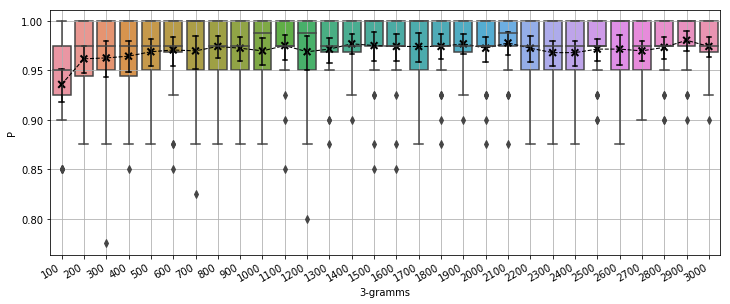

In [9]:
#SVM with rbf kernel
params = {'random_state':42, 'kernel': 'rbf'} 
df_list = {}
for ngrams in tqdm_notebook(range(100, 3100, 100)):
    df_list[ngrams] = calculate_errors(recognizer, SVC, params, n_3gramms=ngrams, random_state=ngrams)
df_errors_svr = pd.DataFrame(df_list)
f, ax = plt.subplots(1, 1)
sns.boxplot(data=df_errors_svr, ax=ax);
sns.pointplot(data=df_errors_svr.values, linestyles='', scale=1, color='k', errwidth=1.5, capsize=0.2, markers='x')
sns.pointplot(data=df_errors_svr.values, linestyles='--', scale=0.4, color='k', errwidth=0, capsize=0, ax=ax)
ax.set_ylabel('P'); ax.set_xlabel('3-gramms'); ax.set_xticklabels([t for t in range(100, 3100, 100)]);
plt.gcf().autofmt_xdate(); ax.grid(); plt.show()

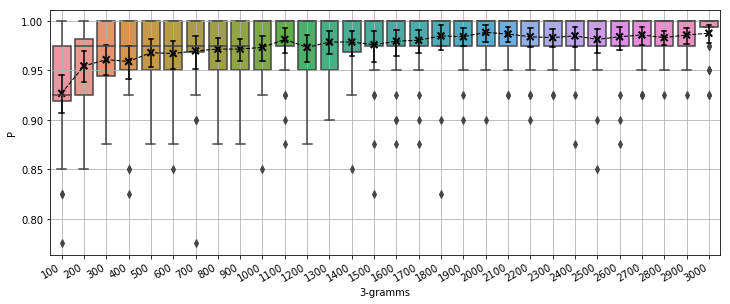

In [10]:
#Logistic regression
params={'random_state':42, 'class_weight':'balanced', 'solver':'liblinear'} 
df_list = {}
for ngrams in tqdm_notebook(range(100, 3100, 100)):
    df_list[ngrams] = calculate_errors(recognizer, LogisticRegression, params, n_3gramms=ngrams, random_state=ngrams) #, scoring='roc_auc'
df_errors_lr = pd.DataFrame(df_list)
f, ax = plt.subplots(1, 1)
sns.boxplot(data=df_errors_lr, ax=ax);
sns.pointplot(data=df_errors_lr.values, linestyles='', scale=1, color='k', errwidth=1.5, capsize=0.2, markers='x')
sns.pointplot(data=df_errors_lr.values, linestyles='--', scale=0.4, color='k', errwidth=0, capsize=0, ax=ax)
ax.set_ylabel('P'); ax.set_xlabel('3-gramms'); ax.set_xticklabels([t for t in range(100, 3100, 100)]);
plt.gcf().autofmt_xdate(); ax.grid(); plt.show()

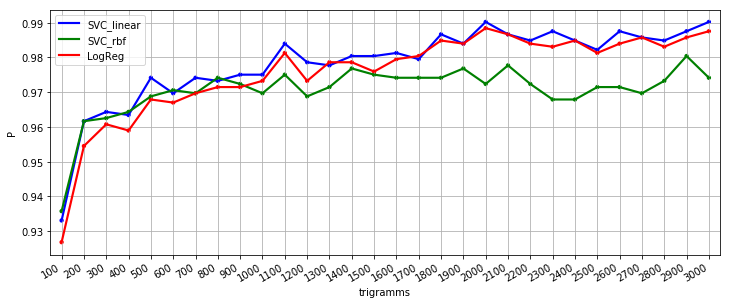

In [11]:
#summary graph for trigramms
trigramms = df_errors_lr.columns
df1 = pd.DataFrame({'trigramms': trigramms, 'P': df_errors_svl.mean()})
df2 = pd.DataFrame({'trigramms': trigramms, 'P': df_errors_svr.mean()})
df3 = pd.DataFrame({'trigramms': trigramms, 'P': df_errors_lr.mean()})
f, ax = plt.subplots(1, 1)
x_col='trigramms'
y_col = 'P'
sns.pointplot(ax=ax,x=x_col,y=y_col,data=df1,color='blue', linestyles='-' , scale=.8, markers='.')  #, capsize=1
sns.pointplot(ax=ax,x=x_col,y=y_col,data=df2,color='green', linestyles='-', scale=.8, markers='.')
sns.pointplot(ax=ax,x=x_col,y=y_col,data=df3,color='red', linestyles='-', scale=.8, markers='.')
ax.legend(handles=ax.lines[::len(df1)+1], labels=["SVC_linear","SVC_rbf","LogReg"]); ax.grid()
ax.set_xticklabels([t for t in range(100, 3100, 100)]); plt.gcf().autofmt_xdate(); plt.show()

Linear SVM and logistic regression show a slightly better result. SVM with the rbf kernel works slightly worse, especially concerning the number of 1000 trigrams or higher.<br>
We will fix the number of trigrams equal to 300 and estimate the probability of the correct recognition of the author of fragments of various length from 1000 to 20,000 characters.

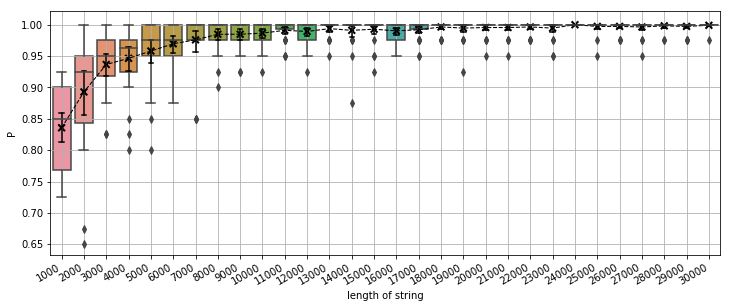

In [12]:
#Logistic regression
params = {'random_state':42, 'kernel': 'linear'}
df_list = {}
for length in tqdm_notebook(range(1000, 31000, 1000)):
    df_list[length] = calculate_errors(recognizer, SVC, params, length_string=length, random_state=length)
df_errors_svl = pd.DataFrame(df_list)
f, ax = plt.subplots(1, 1)
sns.boxplot(data=df_errors_svl, ax=ax);
sns.pointplot(data=df_errors_svl.values, linestyles='', scale=1, color='k', errwidth=1.5, capsize=0.2, markers='x')
sns.pointplot(data=df_errors_svl.values, linestyles='--', scale=0.4, color='k', errwidth=0, capsize=0, ax=ax)
ax.set_ylabel('P'); ax.set_xlabel('length of string'); ax.set_xticklabels([t for t in range(1000, 31000, 1000)])
plt.gcf().autofmt_xdate(); ax.grid(); plt.show()

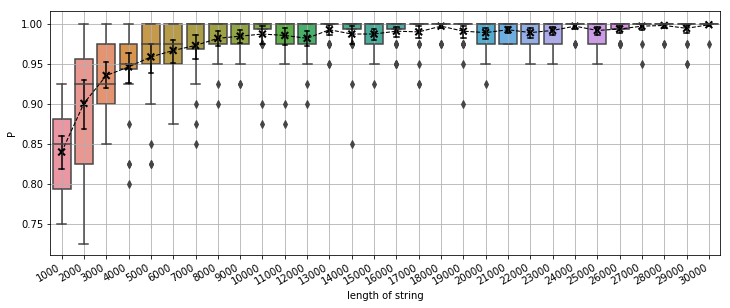

In [13]:
#SVM with rbf kernel
params = {'random_state':42, 'kernel': 'rbf'} 
df_list = {}
for length in tqdm_notebook(range(1000, 31000, 1000)):
    df_list[length] = calculate_errors(recognizer, SVC, params, length_string=length, random_state=length) 
    
df_errors_svr = pd.DataFrame(df_list)
f, ax = plt.subplots(1, 1)
sns.boxplot(data=df_errors_svr, ax=ax);
sns.pointplot(data=df_errors_svr.values, linestyles='', scale=1, color='k', errwidth=1.5, capsize=0.2, markers='x')
sns.pointplot(data=df_errors_svr.values, linestyles='--', scale=0.4, color='k', errwidth=0, capsize=0, ax=ax)
ax.set_ylabel('P'); ax.set_xlabel('length of string'); ax.set_xticklabels([t for t in range(1000, 31000, 1000)])
plt.gcf().autofmt_xdate(); ax.grid(); plt.show()

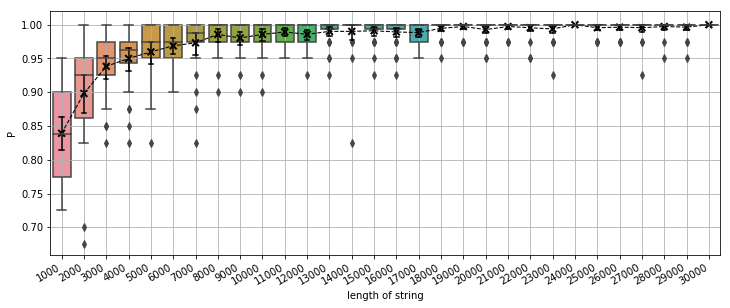

In [14]:
#Logistic regression
params={'random_state':42, 'class_weight':'balanced', 'solver':'liblinear'} #, 'C': 1e-7
df_list = {}
for length in tqdm_notebook(range(1000, 31000, 1000)):
    df_list[length] = calculate_errors(recognizer, LogisticRegression, params, length_string=length, random_state=length) 
df_errors_lr = pd.DataFrame(df_list)
f, ax = plt.subplots(1, 1)
sns.boxplot(data=df_errors_lr, ax=ax);
sns.pointplot(data=df_errors_lr.values, linestyles='', scale=1, color='k', errwidth=1.5, capsize=0.2, markers='x')
sns.pointplot(data=df_errors_lr.values, linestyles='--', scale=0.4, color='k', errwidth=0, capsize=0, ax=ax)
ax.set_ylabel('P'); ax.set_xlabel('length of string'); ax.set_xticklabels([t for t in range(1000, 31000, 1000)])
plt.gcf().autofmt_xdate(); ax.grid(); plt.show()

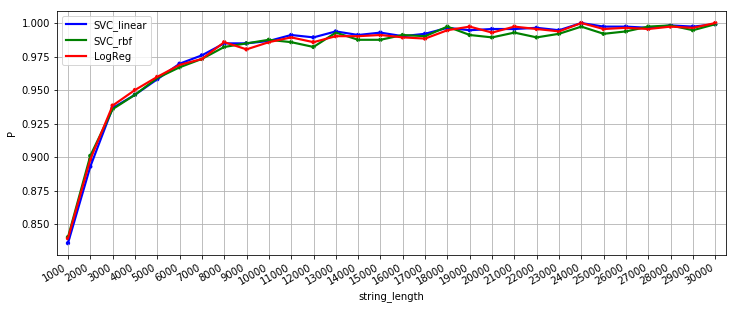

In [15]:
#summary graph for trigramms
string_length = df_errors_lr.columns
df1 = pd.DataFrame({'string_length': string_length, 'P': df_errors_svl.mean()})
df2 = pd.DataFrame({'string_length': string_length, 'P': df_errors_svr.mean()})
df3 = pd.DataFrame({'string_length': string_length, 'P': df_errors_lr.mean()})
f, ax = plt.subplots(1, 1)
x_col='string_length'
y_col = 'P'
sns.pointplot(ax=ax,x=x_col,y=y_col,data=df1,color='blue', linestyles='-' , scale=.8, markers='.')  #, capsize=1
sns.pointplot(ax=ax,x=x_col,y=y_col,data=df2,color='green', linestyles='-', scale=.8, markers='.')
sns.pointplot(ax=ax,x=x_col,y=y_col,data=df3,color='red', linestyles='-', scale=.8, markers='.')
ax.legend(handles=ax.lines[::len(df1)+1], labels=["SVC_linear","SVC_rbf","LogReg"])
ax.set_xticklabels([t for t in range(1000, 31000, 1000)])
plt.gcf().autofmt_xdate()
ax.grid()
plt.show()

Here, the results of all three models are approximately equal. At string lengths of up to 2000 characters, logistic regression and SVM with the rbf kernel perform slightly better. Further, all algorithms show approximately the same results. For the lines of 3000 characters long, the accuracy of author recognition rises to $p > 0.9$.

Let's estimate the effect that initial seven trigrams have on the quality of recognition of author. We will use linear SVM, the number of analysed trigrams is 250, the length of the substring is 5000.

In [16]:
recognizer.set_lang_model(lang_model_size=250, skip=0, smoothing=False, string_size=5000)
n_mean = 0
n = 500
for i in tqdm_notebook(range(n)):
    random.seed(i)
    author1, author2 = random.sample(recognizer.authors, 2)
    params = {'random_state':n, 'kernel': 'linear'}
    mean, std = recognizer.one_against_one(SVC, params, author1, author2, 'accuracy', 25, random_state=i)
    n_mean += mean
print(f'{n_mean / n:.5f}')


0.96688


In [17]:
recognizer.set_lang_model(lang_model_size=250, skip=7, smoothing=False, string_size=5000)
n_mean = 0
n = 500
for i in tqdm_notebook(range(n)):
    random.seed(i)
    author1, author2 = random.sample(recognizer.authors, 2)
    params = {'random_state':n, 'kernel': 'linear'}
    mean, std = recognizer.one_against_one(SVC, params, author1, author2, 'accuracy', 25, random_state=i)
    n_mean += mean
print(f'{n_mean / n:.5f}')


0.96536


When skipping the initial seven trigrams, the probability of recognising the author changes slightly.

### The evaluation of the effect of Laplace's smoothing

When calculating the frequencies of appearance of N-grams in the text as features of identification of the author, the researcher can meet sparse data. It happens when a part of the signs is missing in the corpus estimated since there is not a general sample of data used. Primarily, this problem is relevant for texts of small sizes and high orders N-grams. The solution of the problem is the use of special techniques for smoothing the probabilities (methods by Laplace, Good-Turing, Katz interpolation method, Kneser-Ney method, etc. \[6\]), allowing to estimate the probabilities of non-occurring events. In the works \[3\], \[4\], the Laplace smoothing proved to be the best.
To calculate the N-gram probabilities taking additive smoothing into account, we will use the following expression: <br>
$P_{ADD}(w_{i-n+1}^{i-1})=\frac{\delta+c(w_{i-n+1}^{i})}{\delta V + \sum \limits_{w_{i}} c(w_{i-n+1}^{i})}$,<br>
where c (·) is the number of uses of a given N-gram; V is the number of all N-grams in the vocabulary used.
Laplace smoothing is a particular case of additive smoothing with $delta = 1$
To assess the effect of Laplace's smoothing, we will conduct 500 independent experiments with smoothing turned on and off for randomly selected pairs of authors to compare the probabilities of the correct recognition.
Let's conduct these experiments for two issues:
1. number of the trigrams is 1,000, the length  of the substring is 4,000; in this case, there are sparse data, and using smoothing can be effective
2. number of the trigrams is 300,  the length of the substring is 20000; in this case, there is no sparse data.
We expect that, in the first case, the results with smoothing will differ from the results without smoothing.


In [39]:
recognizer.set_lang_model(lang_model_size=1000, skip=0, smoothing=False, string_size=4000)
n_mean = 0
params = {'C': 1, 'kernel': 'linear'}
n = 500
for i in tqdm_notebook(range(n)):
    random.seed(i*42)
    author1, author2 = random.sample(recognizer.authors, 2)    
    params = {'random_state':n, 'kernel': 'rbf'}
    #params={'random_state':42, 'class_weight':'balanced', 'solver':'liblinear'}
    mean, std = recognizer.one_against_one(SVC, params, author1, author2, 'accuracy', 10, random_state=i)
    n_mean += mean
print(f'{n_mean / n:.5f}')

0.94120


In [40]:
recognizer.set_lang_model(lang_model_size=1000, skip=0, smoothing=True, string_size=4000)
n_mean = 0
n = 500
for i in tqdm_notebook(range(n)):
    random.seed(i*42)
    author1, author2 = random.sample(recognizer.authors, 2)
    params = {'random_state':n, 'kernel': 'rbf'}
    mean, std = recognizer.one_against_one(SVC, params, author1, author2, 'accuracy', 10, random_state=i)
    n_mean += mean
print(f'{n_mean / n:.5f}')

0.93790


In [41]:
recognizer.set_lang_model(lang_model_size=300, skip=0, smoothing=False, string_size=20000)
n_mean = 0
n = 500
for i in tqdm_notebook(range(n)):
    random.seed(i*42)
    author1, author2 = random.sample(recognizer.authors, 2)
    params = {'random_state':n, 'kernel': 'rbf'}
    mean, std = recognizer.one_against_one(SVC, params, author1, author2, 'accuracy', 10, random_state=i)
    n_mean += mean
print(f'{n_mean / n:.5f}')

0.97730


In [42]:
recognizer.set_lang_model(lang_model_size=300, skip=0, smoothing=True, string_size=20000)
n_mean = 0
n = 500
for i in tqdm_notebook(range(n)):
    random.seed(i*42)
    author1, author2 = random.sample(recognizer.authors, 2)
    params = {'random_state':n, 'kernel': 'rbf'}
    mean, std = recognizer.one_against_one(SVC, params, author1, author2, 'accuracy', 10, random_state=i)
    n_mean += mean
print(f'{n_mean / n:.5f}')

0.97730


As we can see, smoothing slightly affect to result in both cases. Perhaps this is because in \[3\] and \[4\] samples of a much smaller size were used, in the amount of 2 for each author and no regularisation of the model was carried out.

## Author Recognition
Until now, we have tried to predict the author for one sample of text for all possible pairs of $(M = \frac{N(N-1)}{2})$ authors, where $N$ is the number of authors.
In general, each text consists of several fragments and the number of prospective authors may be more than two.
Let's consider the multiclass classification problem. Initially, all classifiers were trained in the "train" corpus to recognise all authors from the list recognizer.authors. The size of the training subsample was set by the `train_size` parameter of the` fit` method. For classifiers based on SVM, we applied the `one against one` scheme, and each classifier was trained on equal subsamples for each of the authors. For LogisticRegression, the `one against all` scheme was applied, and each classifier was trained on a subsample *of its* author and a $N-1$ subsample of all other authors. Thus, the training sample was unbalanced.
Author recognition was implemented by the `predict` method. Recognition process was as follows. The entire text sample was divided into substrings of the selected length, with the total number of $ m $ substrings. We calculated the number of trigrams for each substring. Thus, we obtained a matrix of $m \times l$ size, where $l$ is the number of trigrams that is accounted for in  in the  language model - *lang_model_size*. Then, the matrix was passed to the `predict` method of each classifier. Thus, for each of the substrings, we got the forecast of recognition of the author. Positive forecasts were summed up by classifiers and substrings, then the final choice of the author was made by majority voting for the entire text.
For `LogisticRegression` in the `one against all` scheme, we chose the `predict` method instead of the ` predict_proba` since it turned out that there was the more accurate final result.
In previous experiments, we obtained excellent results for a substring of a length of 20,000 characters with the number of trigrams of 2000. Further, we will apply these values. We will not use smoothing or skip initial trigrams.
We will recognise the author for each text from the test corpus and display the results in a table. In case of an incorrect result, we will also display the name of the file containing the prediction error.

In [43]:
test_corpus = '../test_corpus/'
ilf_petrov = '../IlfPetrov/'
string_size = 20000
train_size=15
lang_model_size=2000

recognizer.set_lang_model(lang_model_size=lang_model_size,
                          skip=0, smoothing=False,
                          string_size=string_size)

def predict_author(recognizer, PATH='../test_corpus/'):
    files = listdir(PATH)
    true = 0
    all = 0
    print(' ________________________________________ ')
    print('| real author | predicted author| matched ')
    
    for file in files:
        author = file.split('_')[0]
        if author in recognizer.authors:
            all += 1
            pred_author =  recognizer.predict(path.join(PATH, file))#   path.join((path, ))
            print( f'| {author}{" " * (12 - len(author))}|  {pred_author}{" " * (15 - len(pred_author))}| {author == pred_author}', end=" ")
            if author == pred_author:
                true +=1
                print()
            else:
                print(file)
    print('|________________________________________ ')    
    if PATH != '../IlfPetrov/':
        print(f'Accuracy {100 * true / all:.2f}%', end='\n\n')                    

#### SVM with *linear* kernel

In [44]:
params = {'random_state':42, 'kernel':'linear'} 
recognizer.fit(model=SVC, params=params, mode='oao', train_size=train_size, random_state=42)
predict_author(recognizer=recognizer, PATH=test_corpus)
predict_author(recognizer=recognizer, PATH=ilf_petrov)

 ________________________________________ 
| real author | predicted author| matched 
| Gaidar      |  Gaidar         | True 
| Platonov    |  Bulgakov       | False Platonov_усомнившийся_макар_string.txt
| Grin        |  Grin           | True 
| Gaidar      |  Gaidar         | True 
| Kataev      |  Bulgakov       | False Kataev_остров_эрендорф_string.txt
| Platonov    |  Platonov       | True 
| Gorky       |  Gorky          | True 
| Grin        |  Grin           | True 
| Gaidar      |  Gaidar         | True 
| Olesha      |  Bulgakov       | False Olesha_три_толстяка_string.txt
| Kataev      |  Kataev         | True 
| Bulgakov    |  Bulgakov       | True 
| Grin        |  Grin           | True 
| Bulgakov    |  Bulgakov       | True 
| Gorky       |  Gorky          | True 
| Olesha      |  Olesha         | True 
| Gaidar      |  Gaidar         | True 
|________________________________________ 
Accuracy 82.35%

 ________________________________________ 
| real author | predicted a

#### SVM with *rbf* kernel

In [45]:
params = {'random_state':42,'kernel':'rbf'}
recognizer.fit(model=SVC, params=params, mode='oao', train_size=train_size, random_state=42)
predict_author(recognizer=recognizer, PATH=test_corpus)
predict_author(recognizer=recognizer, PATH=ilf_petrov)

 ________________________________________ 
| real author | predicted author| matched 
| Gaidar      |  Gaidar         | True 
| Platonov    |  Bulgakov       | False Platonov_усомнившийся_макар_string.txt
| Grin        |  Bulgakov       | False Grin_дорога_в_никуда_string.txt
| Gaidar      |  Bulgakov       | False Gaidar_голубая_чашка_string.txt
| Kataev      |  Bulgakov       | False Kataev_остров_эрендорф_string.txt
| Platonov    |  Bulgakov       | False Platonov_эфирный_тракт_string.txt
| Gorky       |  Gorky          | True 
| Grin        |  Bulgakov       | False Grin_алые_паруса_string.txt
| Gaidar      |  Gaidar         | True 
| Olesha      |  Bulgakov       | False Olesha_три_толстяка_string.txt
| Kataev      |  Kataev         | True 
| Bulgakov    |  Bulgakov       | True 
| Grin        |  Grin           | True 
| Bulgakov    |  Bulgakov       | True 
| Gorky       |  Gorky          | True 
| Olesha      |  Olesha         | True 
| Gaidar      |  Gaidar         | True 
|___

#### LogisticRegression

In [46]:
params={'random_state':42, 'class_weight':'balanced', 'solver':'liblinear'}
recognizer.fit(model=LogisticRegression, params=params, mode='oaa', train_size=train_size, random_state=42)
predict_author(recognizer=recognizer, PATH=test_corpus)
predict_author(recognizer=recognizer, PATH=ilf_petrov)

 ________________________________________ 
| real author | predicted author| matched 
| Gaidar      |  Gaidar         | True 
| Platonov    |  Platonov       | True 
| Grin        |  Grin           | True 
| Gaidar      |  Gaidar         | True 
| Kataev      |  Bulgakov       | False Kataev_остров_эрендорф_string.txt
| Platonov    |  Platonov       | True 
| Gorky       |  Gorky          | True 
| Grin        |  Grin           | True 
| Gaidar      |  Gaidar         | True 
| Olesha      |  Bulgakov       | False Olesha_три_толстяка_string.txt
| Kataev      |  Kataev         | True 
| Bulgakov    |  Bulgakov       | True 
| Grin        |  Grin           | True 
| Bulgakov    |  Bulgakov       | True 
| Gorky       |  Gorky          | True 
| Olesha      |  Olesha         | True 
| Gaidar      |  Gaidar         | True 
|________________________________________ 
Accuracy 88.24%

 ________________________________________ 
| real author | predicted author| matched 
| IlfPetrov   |  IlfPet

Linear SVM and LogisticRegression show the best results on the training corpus, and both define Bulgakov as the author of the novel “The Twelve Chairs”, but linear SVM  defines Ilf and Petrov as the authors of “Golden Calf”. The SVM with rbf kernel shows a worse result, but it recognises Bulgakov as the author of both novels.

## Authorship Hypothesis Testing

In the previous experiment, we could not unambiguously identify the author for the novels "The Twelve Chairs" and "Golden Calf". We will put a strict question, who was the authors, Ilf and Petrov, or Bulgakov?
To select the proposed author, in the Recognizer class we will use a `hypothesis_test` method of our class. In the `one against one` scheme, it is all simple. We already have got trained classifiers for each of the pairs of authors, and it is enough to use them to recognise.
If there are classifiers trained in the `one against one` scheme, we have two possibilities:
* for classifiers trained on the texts of each of the authors, we can call the `predict_proba` method and select the result from the obtained probabilities using the `softmax` method
* we can teach a new classifier on the texts of two authors, i.e. reduce the task to the `one against one` scheme. In this case, it is reasonable to use `roc_auc` as a metric.
We will use all the tools.

Let's experiment in the following way. For each text, in the test corpus, we will make the real author playoff against any other, one by one. We will calculate the `accuracy` and determine the names of the files where the author is defined incorrectly. First, we will experiment with the test corpus; then we will check the works of Ilf and Petrov.

In [47]:
def test_hyppo(recognizer, PATH='../test_corpus/', softmax=False):
    files = listdir(PATH)
    true = 0; all = 0
    print('________________________________________________')    
    for file in files:
        real_author = file.split('_')[0]
        if real_author not in recognizer.authors:
            continue
        another_authors = recognizer.authors.copy()
        another_authors.remove(real_author)
        for author in another_authors:     
            
            all += 1
            pred =  recognizer.hypothesis_test(path.join(PATH, file), author, real_author, softmax=softmax)
            #pdb.set_trace()
            pred_author = pred[pred == pred.max()].index[0]
            if real_author == pred_author:
                true +=1
            else:
                print(f'{file} - {author}')   
    if PATH != '../IlfPetrov/':
        print(f'Accuracy {100 * true / all:.2f}% in {all} experiments')   
    

#### SVM with *linear* kernel

In [48]:
params = {'random_state':42, 'kernel':'linear'}
recognizer.fit(model=SVC, params=params, mode='oao', train_size=train_size, random_state=42)
test_hyppo(recognizer=recognizer)
test_hyppo(recognizer=recognizer, PATH=ilf_petrov)
print()
print('12 Chairs')
print(recognizer.hypothesis_test('../IlfPetrov/IlfPetrov_12chairs_string.txt', 'IlfPetrov', 'Bulgakov'), end='\n\n')
print('The Golden Calf')
print(recognizer.hypothesis_test('../IlfPetrov/IlfPetrov_золотой_теленок_string.txt', 'IlfPetrov', 'Bulgakov'))

________________________________________________
Kataev_остров_эрендорф_string.txt - Bulgakov
Kataev_остров_эрендорф_string.txt - IlfPetrov
Olesha_три_толстяка_string.txt - Bulgakov
Olesha_три_толстяка_string.txt - Gaidar
Olesha_три_толстяка_string.txt - Gorky
Olesha_три_толстяка_string.txt - Kataev
Accuracy 94.96% in 119 experiments
________________________________________________
IlfPetrov_однажды_летом_string.txt - Olesha
IlfPetrov_12chairs_string.txt - Bulgakov

12 Chairs
IlfPetrov    0.454545
Bulgakov     0.545455
dtype: float64

The Golden Calf
IlfPetrov    0.875
Bulgakov     0.125
dtype: float64


#### SVM with *rbf* kernel

In [49]:
params = {'random_state':42, 'kernel':'rbf'}
recognizer.fit(model=SVC, params=params, mode='oao', train_size=train_size, random_state=42)
test_hyppo(recognizer=recognizer)
test_hyppo(recognizer=recognizer, PATH=ilf_petrov)
print()
print('12 Chairs')
print(recognizer.hypothesis_test('../IlfPetrov/IlfPetrov_12chairs_string.txt', 'IlfPetrov', 'Bulgakov'), end='\n\n')
print('The Golden Calf')
print(recognizer.hypothesis_test('../IlfPetrov/IlfPetrov_золотой_теленок_string.txt', 'IlfPetrov', 'Bulgakov'))

________________________________________________
Platonov_усомнившийся_макар_string.txt - Bulgakov
Platonov_усомнившийся_макар_string.txt - Kataev
Platonov_усомнившийся_макар_string.txt - Olesha
Grin_дорога_в_никуда_string.txt - Bulgakov
Grin_дорога_в_никуда_string.txt - Olesha
Gaidar_голубая_чашка_string.txt - Bulgakov
Kataev_остров_эрендорф_string.txt - Bulgakov
Platonov_эфирный_тракт_string.txt - Kataev
Grin_алые_паруса_string.txt - Bulgakov
Gaidar_повести_рассказы_2_string.txt - Kataev
Olesha_три_толстяка_string.txt - Bulgakov
Olesha_три_толстяка_string.txt - Gaidar
Olesha_три_толстяка_string.txt - Kataev
Accuracy 89.08% in 119 experiments
________________________________________________
IlfPetrov_однажды_летом_string.txt - Bulgakov
IlfPetrov_однажды_летом_string.txt - Gaidar
IlfPetrov_однажды_летом_string.txt - Kataev
IlfPetrov_однажды_летом_string.txt - Olesha
IlfPetrov_12chairs_string.txt - Bulgakov
IlfPetrov_12chairs_string.txt - Kataev

12 Chairs
IlfPetrov    0.181818
Bulgakov

#### LogisticRegression like a *one-agains-one*

In [50]:
params={'random_state':42, 'class_weight':'balanced', 'solver':'liblinear'}
recognizer.fit(model=LogisticRegression, params=params, mode='oaa', train_size=train_size, random_state=42)
test_hyppo(recognizer=recognizer)
test_hyppo(recognizer=recognizer, PATH=ilf_petrov)
print()
print("'12 Chairs'")
print(recognizer.hypothesis_test('../IlfPetrov/IlfPetrov_12chairs_string.txt', 'IlfPetrov', 'Bulgakov'), end='\n\n')
print("'The Golden Calf'")
print(recognizer.hypothesis_test('../IlfPetrov/IlfPetrov_золотой_теленок_string.txt', 'IlfPetrov', 'Bulgakov'))

________________________________________________
Kataev_остров_эрендорф_string.txt - Bulgakov
Olesha_три_толстяка_string.txt - Bulgakov
Olesha_три_толстяка_string.txt - Gaidar
Olesha_три_толстяка_string.txt - Kataev
Bulgakov_белая_гвардия_string.txt - Kataev
Accuracy 95.80% in 119 experiments
________________________________________________
IlfPetrov_однажды_летом_string.txt - Kataev
IlfPetrov_однажды_летом_string.txt - Olesha
IlfPetrov_золотой_теленок_string.txt - Bulgakov
IlfPetrov_золотой_теленок_string.txt - Kataev
IlfPetrov_12chairs_string.txt - Bulgakov
IlfPetrov_12chairs_string.txt - Kataev

'12 Chairs'
IlfPetrov    0.5
Bulgakov     0.5
dtype: float64

'The Golden Calf'
IlfPetrov    0.5
Bulgakov     0.5
dtype: float64


#### LogisticRegression with the *softmax*

In [51]:
params={'random_state':42, 'class_weight':'balanced', 'solver':'liblinear'}
recognizer.fit(model=LogisticRegression, params=params, mode='oaa', train_size=train_size, random_state=42)
test_hyppo(recognizer=recognizer, softmax=True)
test_hyppo(recognizer=recognizer, PATH=ilf_petrov, softmax=True)
print()
print("'12 Chairs'")
print(recognizer.hypothesis_test('../IlfPetrov/IlfPetrov_12chairs_string.txt', 'IlfPetrov', 'Bulgakov'), end='\n\n')
print("'The Golden Calf'")
print(recognizer.hypothesis_test('../IlfPetrov/IlfPetrov_золотой_теленок_string.txt', 'IlfPetrov', 'Bulgakov'))

________________________________________________
Gaidar_бумбараш_string.txt - Kataev
Platonov_усомнившийся_макар_string.txt - Bulgakov
Gaidar_голубая_чашка_string.txt - Kataev
Kataev_остров_эрендорф_string.txt - Bulgakov
Platonov_эфирный_тракт_string.txt - Bulgakov
Grin_алые_паруса_string.txt - Kataev
Gaidar_повести_рассказы_2_string.txt - Kataev
Olesha_три_толстяка_string.txt - Bulgakov
Olesha_три_толстяка_string.txt - Gaidar
Olesha_три_толстяка_string.txt - Gorky
Olesha_три_толстяка_string.txt - Grin
Olesha_три_толстяка_string.txt - IlfPetrov
Olesha_три_толстяка_string.txt - Kataev
Olesha_три_толстяка_string.txt - Platonov
Gaidar_повести_рассказы_string.txt - Bulgakov
Gaidar_повести_рассказы_string.txt - Kataev
Accuracy 86.55% in 119 experiments
________________________________________________
IlfPetrov_однажды_летом_string.txt - Kataev
IlfPetrov_однажды_летом_string.txt - Olesha
IlfPetrov_золотой_теленок_string.txt - Bulgakov
IlfPetrov_золотой_теленок_string.txt - Kataev
IlfPetrov_1

We obtained the best accuracy using the SVM with linear kernel and LogisticRegression *one-against-one*. In the first issue, the algorithm recognises Bulgakov as the author of "The Twelve Chairs" but with a minimum margin, in the second we've got a draw - 05 : 0.5 for both works.

I would also like to mention that:

1. In most experiments, Mikhail Bulgakov was recognised as the real author of Valentin Kataev's "Erendorf Island". The story was written in 1924. We know that, at that time, Kataev and Bulgakov worked together for the Moscow "Gudok" newspaper. Bulgakov's works were published little, so he could write the story and ask Kataev to publish it under his name for a fee (but it is not exactly).

2. Many classifiers have difficulties in recognising the author of the novel "The Three Fat Men" as if Olesha did not write it. Perhaps, the novel was edited in the middle of the XX century. For this reason, we exclude Lev Kassil’s novel “The Black Book and Schwambrania” from the training building when guessing that the novel was significantly revised in the 1950s (but it is not exactly too).

### <center> Conclusions </center>
 
In this project, we've considered one of the methods of recognising authors of the books, based on the calculation of the most frequently appeared trigrams. We attempted to recognise the authors of the novels "The Twelve Chairs" and "Golden Calf". Based on the results of the project, we can conclude that:

1. The proposed method shows good results in recognising authors, but it strongly depends on parameters, such as the number of trigrams used, the length of the substrings being analyzed. With small changes in parameters, the results can vary. Moreover, although the overall picture will change slightly, for individual issues, the results may be radically opposite.
2. This method applies to the large texts only. We analysed the strings with a length of 20,000 characters. For small texts, this method is not suitable.
3. We used three algorithms, the logistic regression, and two types of SVM, with linear and rbf kernels. The best results were obtained using Logistic Regression; the worst was for SVM rbf kernel.
4. The authorship of the novels "The Twelve Chairs" and "Golden Calf" cannot be unambiguously recognised but for us, it seems that the hypothesis of Bulgakov's is reasonable. More research is needed in this area. Perhaps, the use of structures of higher hierarchies (word forms, grammatical classes, syntactic structures) will give more reliable results.

### <center>References</center>

1. Ирина Амлински "12 стульев от Михаила Булгакова", Berlin, Kirschner-Verlag, 2013
2. Дмитрий Галковский <a href="https://galkovsky.livejournal.com/258370.html">"Что необходимо знать о Михаиле Булгакове"</a>
3. [А.С. Романов "Методика идентификации автора текста на основе аппарата опорных векторов"](https://docplayer.ru/29386403-Metodika-identifikacii-avtora-teksta-na-osnove-apparata-opornyh-vektorov.html)
4. [Романов А. С. "Идентификация автора текста с помощью аппарата опорных векторов в случае двух возможных альтернатив"](http://www.dialog-21.ru/media/1617/67.pdf)
5. Михаил Копотев "Введение в корпусную лингвистику",  Praha, Animedia Company, 2014
6. Chen S.F. An empirical study of smoothing techniques for language modeling S.F. Chen,J. Goodman  Computer Speech & Language. – 1999. – Vol. 13, № 4.
7. В.П.Фоменко, Т.Г.Фоменко ["Авторский инвариант русских литературных текстов"](http://chronologia.org/seven2_2/add3.html)
